# Проект 2. Разведывательный анализ данных


Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 30) # показывать больше колонок
pd.set_option('display.max_columns', 30) # показывать больше колонок

data = pd.read_csv('stud_math.csv')


In [60]:
# метод для обреза по iqr с двух сторон
def remove_outliers(df, columns):
    for col in columns:
        if ((df[col].dtype=='float64') | (df[col].dtype=='int64')):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            df = df.loc[df[col].between(q1 - 1.5 * iqr, q3 + 1.5 * iqr)]
    return df

# метод для обреза по iqr сверху
def remove_outliers_top(df, columns):
    for col in columns:
        if ((df[col].dtype=='float64') | (df[col].dtype=='int64')):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            df = df.loc[df[col] < (q3 + 1.5 * iqr)]
    return df

# метод для теста Стьюдента
def get_stat_dif(df, column):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# метод для рисования боксовых графиков
def get_boxplot(df, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index)],
               ax=ax)
    plt.xticks()
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Первичная обработка

In [61]:
# Проверим числовые параметры

data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [62]:
# Удаляем колонку "studytime, granular" (данные отрицательные и кратные 3 - не понятно о чём эти данные говорят)

data.drop(columns=['studytime, granular'], inplace=True)

In [63]:
# Основная масса - в районе 16-18 лет. Удаляем записи нескольких учеников, которые значительно старше остальных.

data.drop(data[data.age > 19].index, inplace = True) 

data.age.value_counts()

16    104
17     98
18     82
15     82
19     24
Name: age, dtype: int64

In [64]:
# Fedu содержит невалидное значение, равное 40. Можно предположить что это опечатка и имелось ввиду 4, но лучше удалить эту запись.

data.drop(data[data.Fedu == 40].index, inplace = True) 

data.Fedu.value_counts()

2.0    103
3.0     96
4.0     88
1.0     76
0.0      2
Name: Fedu, dtype: int64

In [65]:
# Есть запись с невалидным значением famrel (-1) - удаляем

data.drop(data[data.famrel == -1].index, inplace = True) 

data.famrel.value_counts()

4.0    182
5.0     93
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

<AxesSubplot:>

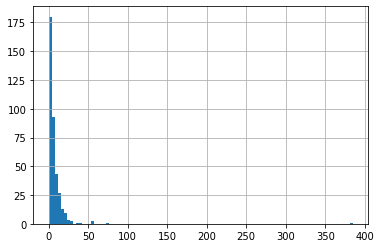

In [66]:
data.absences.hist(bins=100)

In [67]:
# absenses содержит экстремально высокие значения, стоит обрезать сверху.

# Только шестеро пропустили больше 30 раз. Удаляем их
# data.drop(data[data.absences > 30].index, inplace = True) 

data = remove_outliers_top(data, ['absences']) # Удаляем 32 прогульщика с 20 и более прогулами и пустые значения

<AxesSubplot:>

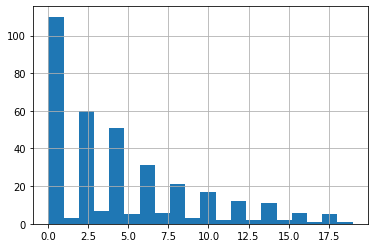

In [68]:
data.absences.hist(bins=20)

In [69]:
data.describe()

# Все числовые значения в порядке

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,356.000000,353.000000,333.000000,328.000000,351.000000,337.000000,331.000000,348.000000,348.000000,341.000000,356.000000,351.000000
mean,16.603933,2.750708,2.498498,1.439024,2.059829,0.293769,3.951662,3.244253,3.094828,3.551320,4.393258,51.851852
std,1.188151,1.107903,1.093862,0.701201,0.854808,0.698461,0.899876,0.972591,1.105228,1.385165,4.685291,23.086564
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,42.500000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,3.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,6.250000,70.000000
max,19.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,19.000000,100.000000


In [70]:
# Изучим пропуски

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      356 non-null    object 
 1   sex         356 non-null    object 
 2   age         356 non-null    int64  
 3   address     342 non-null    object 
 4   famsize     335 non-null    object 
 5   Pstatus     320 non-null    object 
 6   Medu        353 non-null    float64
 7   Fedu        333 non-null    float64
 8   Mjob        340 non-null    object 
 9   Fjob        323 non-null    object 
 10  reason      339 non-null    object 
 11  guardian    328 non-null    object 
 12  traveltime  328 non-null    float64
 13  studytime   351 non-null    float64
 14  failures    337 non-null    float64
 15  schoolsup   348 non-null    object 
 16  famsup      322 non-null    object 
 17  paid        318 non-null    object 
 18  activities  342 non-null    object 
 19  nursery     340 non-null    o

In [71]:
# Ввиду маленькой выборки, постараемся сохранить данные вместо их удаления
# Использование моды может исказить данные маленькой выборки, так что заменим пустые номинативные данные словом "unknown"
# Заменим пропуски

data.fillna({
    # 'school':'unknown', # Пропусков нет
    # 'sex':'unknown', # Пропусков нет
    'address':'unknown',
    'famsize':'unknown',
    'Pstatus':'unknown',
    'Medu': data.Medu.mean(),
    'Fedu': data.Fedu.mean(),
    'Mjob':'unknown',
    'Fjob':'unknown',
    'reason':'unknown',
    'guardian':'unknown',
    'traveltime': data.traveltime.mean(),
    'studytime': data.studytime.mean(),
    'failures': data.failures.mean(),
    'schoolsup': 'unknown',
    'famsup': 'unknown',    
    'paid': 'unknown',
    'activities': 'unknown',
    'nursery': 'unknown',
    'higher': 'unknown',
    'internet': 'unknown',
    'romantic': 'unknown',
    'famrel': data.famrel.mean(),
    'freetime': data.freetime.mean(),
    'goout': data.freetime.mean(),
    'health': data.freetime.mean(),
    # 'absences': data.freetime.mean() # Пропусков нет
    # 'score': 0 # Рассмотрим отдельно
    }, inplace=True)

In [72]:
# Проверим пропуски ещё раз

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      356 non-null    object 
 1   sex         356 non-null    object 
 2   age         356 non-null    int64  
 3   address     356 non-null    object 
 4   famsize     356 non-null    object 
 5   Pstatus     356 non-null    object 
 6   Medu        356 non-null    float64
 7   Fedu        356 non-null    float64
 8   Mjob        356 non-null    object 
 9   Fjob        356 non-null    object 
 10  reason      356 non-null    object 
 11  guardian    356 non-null    object 
 12  traveltime  356 non-null    float64
 13  studytime   356 non-null    float64
 14  failures    356 non-null    float64
 15  schoolsup   356 non-null    object 
 16  famsup      356 non-null    object 
 17  paid        356 non-null    object 
 18  activities  356 non-null    object 
 19  nursery     356 non-null    o

count    351.000000
mean      51.851852
std       23.086564
min        0.000000
25%       42.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64


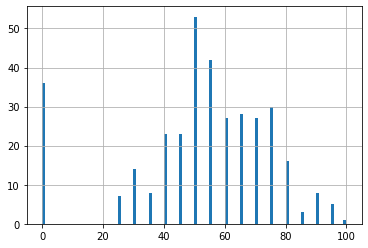

In [73]:
# Проверим основной параметр, по которому мы будем судить учеников - score

data.score.hist(bins=100)
print(data.score.describe())

In [74]:
# Есть пропуски и значения равные 0, в то время как все остальные ученики имеют балл выше 20. Считаем нули и пустые значения нерепрезентативными и удаляем.

data = data.loc[data.score > 20]

In [75]:
# Изучим номинативные переменные

print(data.school.value_counts())
print(data.sex.value_counts())
print(data.address.value_counts())
print(data.famsize.value_counts())
print(data.Pstatus.value_counts())
print(data.Mjob.value_counts())
print(data.Fjob.value_counts())
print(data.reason.value_counts())
print(data.guardian.value_counts())
print(data.schoolsup.value_counts())
print(data.famsup.value_counts())
print(data.paid.value_counts())
print(data.activities.value_counts())
print(data.nursery.value_counts())
print(data.higher.value_counts())
print(data.internet.value_counts())
print(data.romantic.value_counts())

# Всё в порядке.

GP    278
MS     37
Name: school, dtype: int64
F    161
M    154
Name: sex, dtype: int64
U          237
R           66
unknown     12
Name: address, dtype: int64
GT3        204
LE3         93
unknown     18
Name: famsize, dtype: int64
T          254
unknown     32
A           29
Name: Pstatus, dtype: int64
other       103
services     76
teacher      48
at_home      45
health       29
unknown      14
Name: Mjob, dtype: int64
other       158
services     78
unknown      29
teacher      22
health       14
at_home      14
Name: Fjob, dtype: int64
course        108
reputation     86
home           77
other          29
unknown        15
Name: reason, dtype: int64
mother     202
father      73
unknown     26
other       14
Name: guardian, dtype: int64
no         263
yes         44
unknown      8
Name: schoolsup, dtype: int64
yes        176
no         108
unknown     31
Name: famsup, dtype: int64
no         152
yes        129
unknown     34
Name: paid, dtype: int64
yes        158
no         1

In [76]:
# В итоге у нас есть 315 записей для анализа

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      315 non-null    object 
 1   sex         315 non-null    object 
 2   age         315 non-null    int64  
 3   address     315 non-null    object 
 4   famsize     315 non-null    object 
 5   Pstatus     315 non-null    object 
 6   Medu        315 non-null    float64
 7   Fedu        315 non-null    float64
 8   Mjob        315 non-null    object 
 9   Fjob        315 non-null    object 
 10  reason      315 non-null    object 
 11  guardian    315 non-null    object 
 12  traveltime  315 non-null    float64
 13  studytime   315 non-null    float64
 14  failures    315 non-null    float64
 15  schoolsup   315 non-null    object 
 16  famsup      315 non-null    object 
 17  paid        315 non-null    object 
 18  activities  315 non-null    object 
 19  nursery     315 non-null    o

# Корреляционный анализ

<AxesSubplot:>

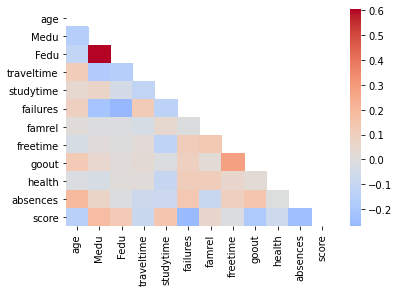

In [77]:
# Изучим корреляцию данных

corr = data.corr()
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0)

In [78]:
# Посмотрим какие числовые параметры влияют на балл

data.corrwith(data.score).round(2)

age          -0.15
Medu          0.18
Fedu          0.13
traveltime   -0.08
studytime     0.14
failures     -0.26
famrel        0.06
freetime     -0.01
goout        -0.19
health       -0.07
absences     -0.24
score         1.00
dtype: float64

<AxesSubplot:>

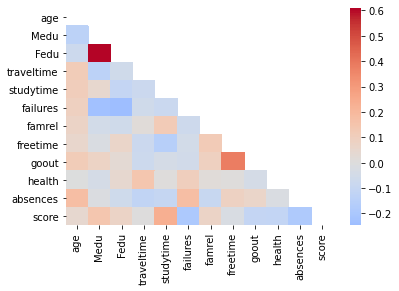

In [79]:
# Посмотрим как менется картина в зависимости от пола
# Интересно, что путь до школы почти не влияет на кол-во проблем у девочек

sns.heatmap(data[data.sex == 'F'].corr(), mask=mask, cmap="coolwarm", center=0)

<AxesSubplot:>

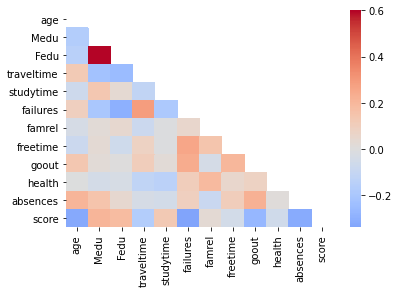

In [80]:
sns.heatmap(data[data.sex == 'M'].corr(), mask=mask, cmap="coolwarm", center=0)

In [81]:
# Как в целом данные отличаются у мальчиков и девочек

data_sex = data.groupby(by=data.sex)
data_sex.mean().round(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
sex,,,,,,,,,,,,
F,16.63,2.74,2.52,1.38,2.31,0.22,3.93,3.07,3.07,3.36,4.86,55.90
M,16.43,2.89,2.53,1.47,1.82,0.24,3.98,3.43,3.11,3.71,4.94,59.74


In [82]:
# Как отличается корреляция данных с баллом у мальчиков и девочек

data_sex.corrwith(data.score).round(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
sex,,,,,,,,,,,,
F,0.05,0.15,0.07,0.00,0.24,-0.19,0.07,-0.02,-0.11,-0.11,-0.18,1.0
M,-0.32,0.21,0.18,-0.17,0.13,-0.34,0.03,-0.05,-0.27,-0.06,-0.31,1.0


## Наблюдения после сопоставления числовых параметров

* Супруги часто имеют схожий уровень образования.
* При этом, чем выше образование родителей, тем лучшие результаты показывает ребёнок на экзамене по математике и является менее проблемным.
* С возрастом, растёт количество пропусков и проблем, причиняемых ребёнком.
* С возрастом идёт понижение среднего балла, но это скорей всего потому что  у старших детей в данной выборке - менее образованные родители.
* Чем дольше ребёнок добирается до школы - тем больше вероятность причинения проблем по пути. И взрослые дети добираются до школы дольше - возможно потому что порой приоритезируют приключения. Зато такие дети более здоровые т.к. проводят больше времени на улице. 
* Числовые параметры, влияющие на балл:
    * Дети с образованными родителями - более успешные в математике, видимо потому что им помогают с уроками дома
    * Дети, которые больше занимаются, имеют более высокие баллы
    * Проблемные и гуляющие дети имеют более низкий балл по математике
* Пол серьёзно влияет на некоторые другие показатели, так что имеет смысл изучать мальчиков и девочек отдельно

# Анализ номинативных переменных

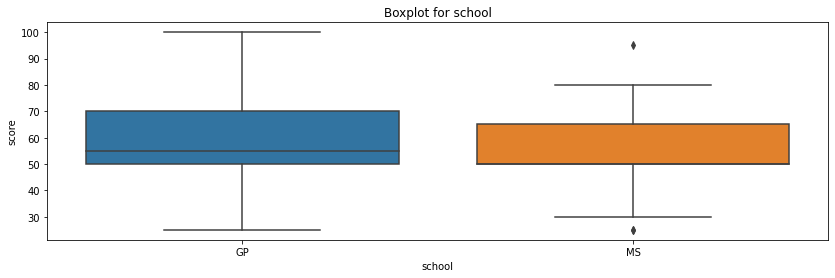

In [83]:
# Школа

get_boxplot(data, 'school')
get_stat_dif(data, 'school')

Подавляющее большинство детей - из школы GP, но не похоже что данные сильно отличаются, так что уровень преподавания математики в обоих школах - схожий.

В данной выборке этот параметр не влияет на балл.

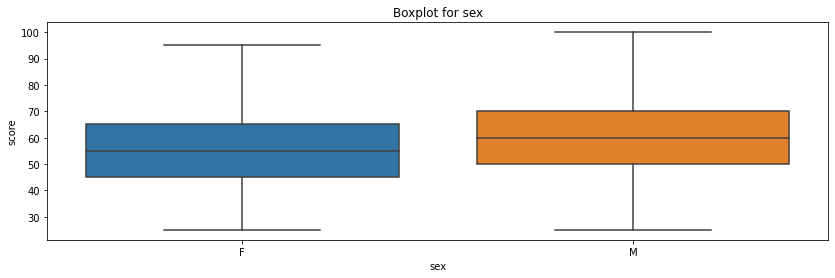

Найдены статистически значимые различия для колонки sex


In [84]:
# Пол

get_boxplot(data, 'sex')
get_stat_dif(data, 'sex')

In [85]:
data_sex.mean().round(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
sex,,,,,,,,,,,,
F,16.63,2.74,2.52,1.38,2.31,0.22,3.93,3.07,3.07,3.36,4.86,55.90
M,16.43,2.89,2.53,1.47,1.82,0.24,3.98,3.43,3.11,3.71,4.94,59.74


In [86]:
data_sex.corrwith(data.score).round(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
sex,,,,,,,,,,,,
F,0.05,0.15,0.07,0.00,0.24,-0.19,0.07,-0.02,-0.11,-0.11,-0.18,1.0
M,-0.32,0.21,0.18,-0.17,0.13,-0.34,0.03,-0.05,-0.27,-0.06,-0.31,1.0


Пол - довольно важный параметр, оказывающий влияние как на балл, так и на другие параметры.

У мальчиков есть предрасположенность к математике из-за лучшего использования левого полушария, но девочки навёрстывают за счёт усердия (они и занимаются больше, и у них studytime коррелирует с баллом сильнее)

Мальчики с возрастом показывают худшие результаты, чем девочки. Это может быть связанно с тем, как у них проходит переходный возраст - они начинают чаще пропускать занятия и проводить больше времени на улице. 

Проблемные девочки не настолько плохи в математике (failures коррелирует с баллом меньше). Видимо потому что "проблемы" у девочек чаще появляются в самой школе, а не за её пределами.

Интересно, что образование матери влияет на мальчиков вдвое сильнее, чем на девочек. Возможно, они более грамотные в воспитании и усмиряют бунтарный дух подростков.

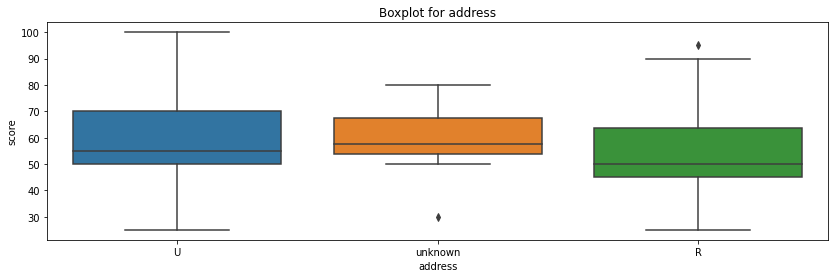

Найдены статистически значимые различия для колонки address


In [87]:
# Адрес

get_boxplot(data, 'address')
get_stat_dif(data, 'address')

In [88]:
get_stat_dif(data, 'address')

Найдены статистически значимые различия для колонки address


80% детей в выборке живут в городе, но 20% тех, что живут на земле - показывают немного худший результат.

Скорей всего этот перевес обеспечивают дети, которые добираются до дома дольше и являются более гуляющими/проблемными.

In [105]:
data.groupby(by=data.address).traveltime.mean().round(2)

address
R          1.79
U          1.32
unknown    1.44
Name: traveltime, dtype: float64

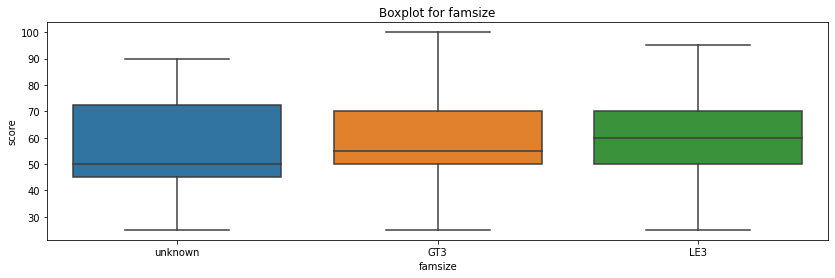

In [90]:
# Размер семьи

get_boxplot(data, 'famsize')
get_stat_dif(data, 'famsize')

В целом, размер семьи слабо влияет на балл. Медиана немного выше в семьях с одним ребёнком, но разница незначительная.

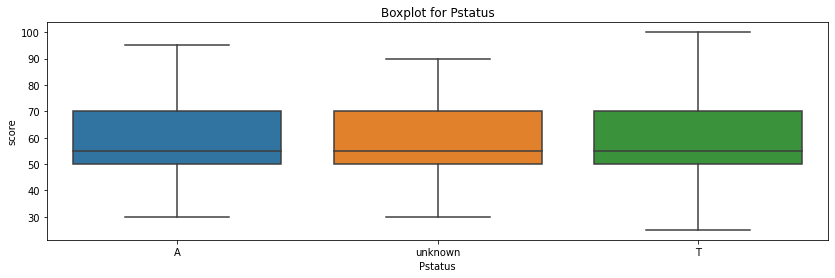

In [91]:
# Жизнь родителей (вместе - раздельно)

get_boxplot(data, 'Pstatus')
get_stat_dif(data, 'Pstatus')

Не похоже, что этот параметр влияет на оценку по математике

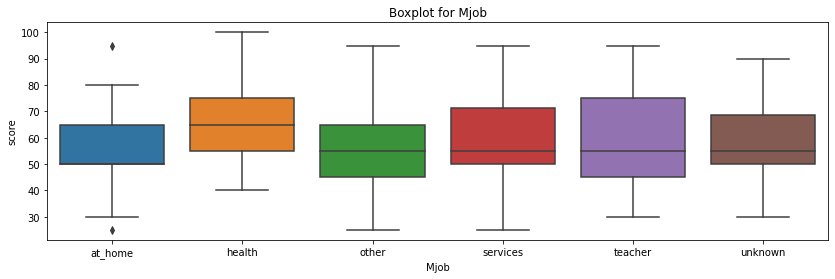

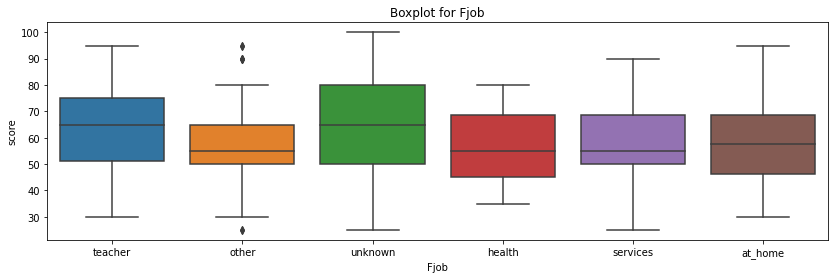

In [92]:
# Образование и работа родителей

get_boxplot(data, 'Mjob')
get_stat_dif(data, 'Mjob')
get_boxplot(data, 'Fjob')
get_stat_dif(data, 'Fjob')

In [93]:
data.groupby(by=data.Mjob).Medu.mean().round(2)

Mjob
at_home     1.67
health      3.62
other       2.52
services    2.87
teacher     3.94
unknown     2.86
Name: Medu, dtype: float64

In [94]:
data.groupby(by=data.Fjob).Fedu.mean().round(2)

Fjob
at_home     2.36
health      3.21
other       2.36
services    2.50
teacher     3.80
unknown     2.31
Name: Fedu, dtype: float64

In [115]:
data.mean().filter(items=['Medu', 'Fedu']).round(2)

Medu    2.81
Fedu    2.53
dtype: float64

Похоже, что образование родителей связанно с оценкой по математике. Образование матери - в меньшей степени, но это может быть потому что матери менее образованы в данной выборке.

Также, отцы-медики и -педагоги, и матери-педагоги положительно сказываются на оценке детей, но это скорей всего связанно с тем что их работа требует образования, так что работа - косвенный параметр.

Матери-медики влияют на образование меньше чем отцы-медики. Возможно потому что среди младшего медицинского персонала женщин больше.

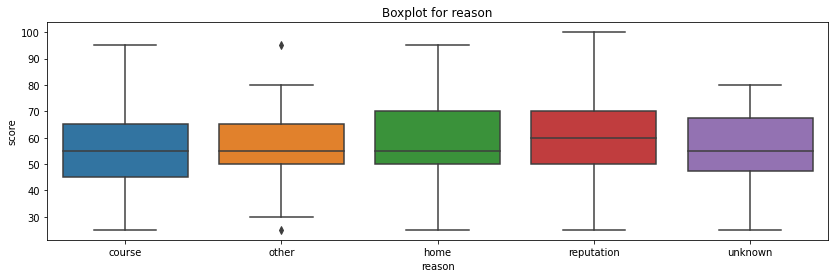

In [96]:
# Причина выбора школы

get_boxplot(data, 'reason')
get_stat_dif(data, 'reason')

Выборка покрывает всего 2 (и относительно равные) школы. Ожидаемо, этот параметр не важен.

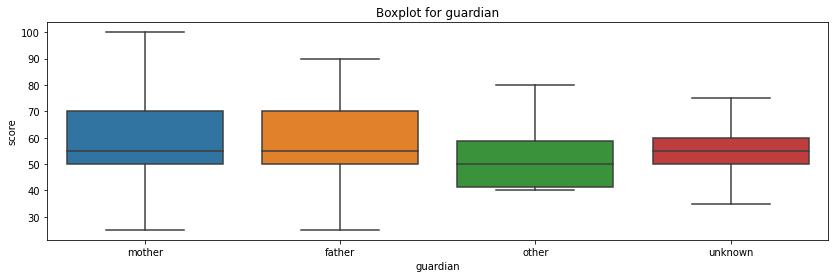

In [97]:
# Опекун

get_boxplot(data, 'guardian')
get_stat_dif(data, 'guardian')

Не похоже, что опекун напрямую влияет на оценку. Косвенно может влиять образование опекуна , и можно было бы проверить корреляцию фичи "guardianEducation" с оценкой, но это вряд ли что-то изменит.

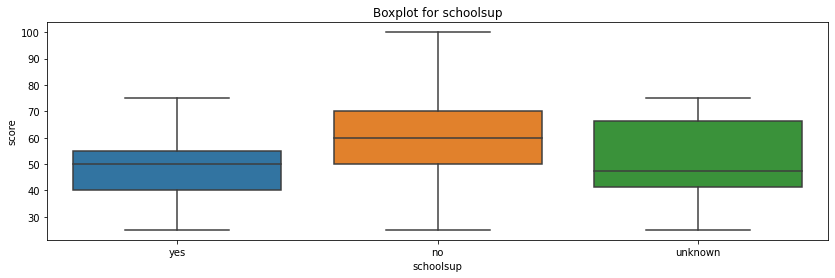

Найдены статистически значимые различия для колонки schoolsup


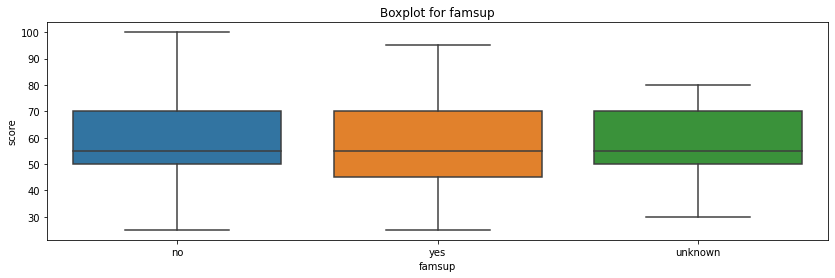

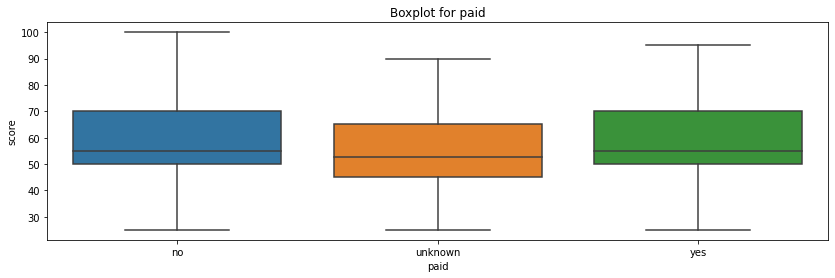

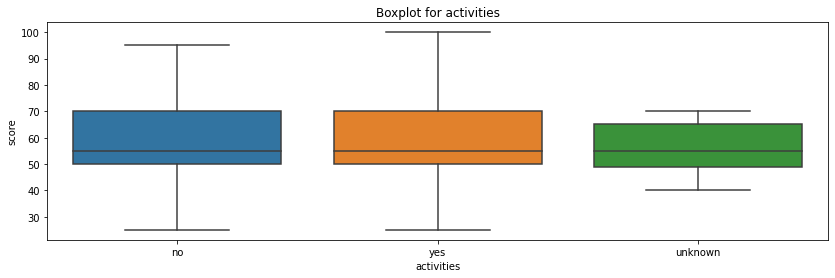

In [98]:
# schoolsup — дополнительная образовательная поддержка (yes или no)
# famsup — семейная образовательная поддержка (yes или no)
# paid — дополнительные платные занятия по математике (yes или no)
# activities — дополнительные внеучебные занятия (yes или no)

get_boxplot(data, 'schoolsup')
get_stat_dif(data, 'schoolsup')
get_boxplot(data, 'famsup')
get_stat_dif(data, 'famsup')
get_boxplot(data, 'paid')
get_stat_dif(data, 'paid')
get_boxplot(data, 'activities')
get_stat_dif(data, 'activities')

Как ни странно, дети с дополнительной поддержкой от школы, показывают худший результат. А остальные виды доп. занятий не улучшают оценку.

In [99]:
data.groupby(by=[data.school, data.schoolsup]).score.mean().round(2)

school  schoolsup
GP      no           60.42
        unknown      51.43
        yes          47.61
MS      no           55.14
        unknown      45.00
Name: score, dtype: float64

Скорей всего школе GP стоит пересмотреть свою программу поддержки.

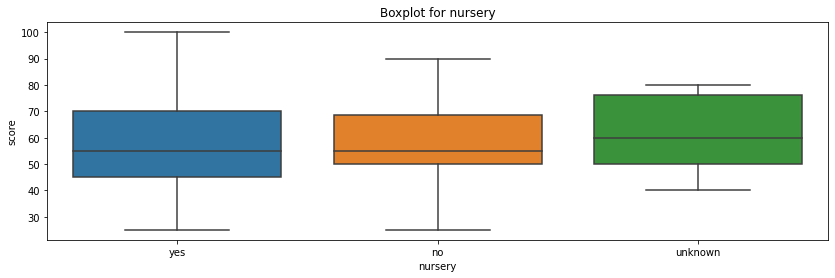

In [100]:
# nursery — посещал детский сад (yes или no)

get_boxplot(data, 'nursery')
get_stat_dif(data, 'nursery')

Не похоже, что детский сад оказывает влияние.

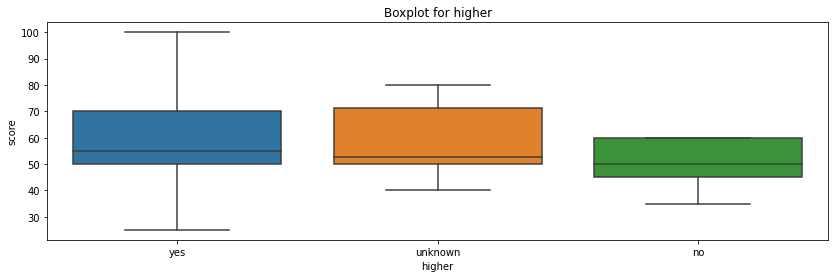

In [101]:
# higher — хочет получить высшее образование (yes или no)

get_boxplot(data, 'higher')
get_stat_dif(data, 'higher')

В выборке всего 9 учеников ответили что не хотят, так что данные не репрезентативны.

Но можно предположить, что желающие обладают большей мотивацией к учебе, и у них ожидаемо, будет лучше результат.

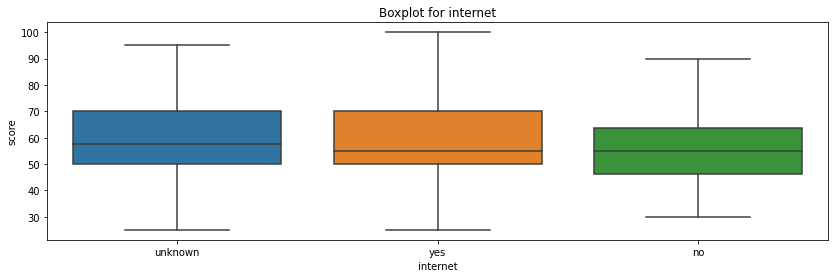

In [102]:
# internet — наличие интернета дома (yes или no)

get_boxplot(data, 'internet')
get_stat_dif(data, 'internet')

Не похоже, что наличие интернета сказывается на балле

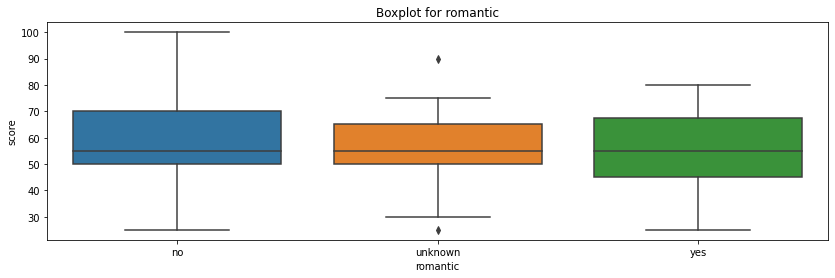

In [103]:
# romantic — в романтических отношениях (yes или no)

get_boxplot(data, 'romantic')
get_stat_dif(data, 'romantic')

Не похоже, что отношения влияют на результаты школьника.

# Выводы

Среди номинативных переменных самая полезная - пол.

Также школьная программа поддержки негативно влияет на балл в данной выборке, но это вряд-ли можно использовать для построения модели. Лучше изучить причины этого отдельно.

Остальные номинативные переменные косвенно указывают на связь числовых перменных с оценкой по математике.

Числовые переменные являются самыми показательными, и могут использоваться для построения модели.
Но корреляционный анализ показал серьёзные различия между мальчикам и и девочками, так что модель должна учитывать пол в первую очередь.

In [104]:
data_sex.corrwith(data.score).round(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
sex,,,,,,,,,,,,
F,0.05,0.15,0.07,0.00,0.24,-0.19,0.07,-0.02,-0.11,-0.11,-0.18,1.0
M,-0.32,0.21,0.18,-0.17,0.13,-0.34,0.03,-0.05,-0.27,-0.06,-0.31,1.0


Из числовых переменных можно выделить следующие:
* Возраст мальчиков - негативная тенденция с увеличением (скорей всего вызвана остальными числовыми параметрами)
* Образование родителей - позитивно сказывается на оценке
* Путь до школы у мальчиков - негативно сказывается на оценке
* Время учёбы - позитивно сказывается на оценке, особенно у девочек
* Проблемность - негативно сказывается на оценке
* Отношения в семье - позитивно сказываются на оценке
* Пропуски/Гуляние - негативно сказывается на оценке, особенно у мальчиков
* Здоровье - негативно сказывается на оценке (скорей всего вызвано подвижностью)